In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**We have Mounted google drive to start work with our data**

In [ ]:
import pandas as pd
import glob

csv_directory = '/content/drive/MyDrive/Comments'

csv_files = glob.glob(csv_directory + "/*.csv")

dataframes = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

print(combined_df.head())


                                             Comment
0  Saw the movie yesterday. It was a good movie, ...
1  i began to wonder if silkworm at same place an...
2                       Has Anyone Saw This In IMAX?
3  Dave Bautista as Yevgeny Prigozhin and Christo...
4  No mentats after Pt 1 made no sense but otherw...


**In this step we have imported the data from google drive and combined all the csv files as one.**

In [ ]:
import re
import numpy as np  # Import numpy for NaN handling

# Use the correct column name 'Comment'
comment_column = 'Comment'

# Define a function to clean text
def clean_text(text):
    if isinstance(text, float) and np.isnan(text):
        return ''  # Return empty string for NaN values
    text = str(text).lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the clean_text function to the 'Comment' column
combined_df['cleaned_comment'] = combined_df[comment_column].apply(clean_text)

# Display the first few rows of the DataFrame with cleaned comments
print(combined_df[[comment_column, 'cleaned_comment']].head())


                                             Comment  \
0  Saw the movie yesterday. It was a good movie, ...   
1  i began to wonder if silkworm at same place an...   
2                       Has Anyone Saw This In IMAX?   
3  Dave Bautista as Yevgeny Prigozhin and Christo...   
4  No mentats after Pt 1 made no sense but otherw...   

                                     cleaned_comment  
0  saw the movie yesterday it was a good movie bu...  
1  i began to wonder if silkworm at same place an...  
2                        has anyone saw this in imax  
3  dave bautista as yevgeny prigozhin and christo...  
4  no mentats after pt made no sense but otherwis...  


**We have preprocessed our data so we can now work on building desired models with it**

# Now we will start working on Emotion detection model

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'combined_df' contains the cleaned comments in the 'cleaned_comment' column
cleaned_comments = combined_df['cleaned_comment']

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned comments using TF-IDF
tfidf_features = tfidf_vectorizer.fit_transform(cleaned_comments)

# Display the shape of the TF-IDF matrix (number of comments, number of unique words)
print("TF-IDF matrix shape:", tfidf_features.shape)


TF-IDF matrix shape: (968353, 200797)


**We have done this step to create TF-IDF matrix of this data so we can get matrix containing numerical representations of the text data.**

In [ ]:
from sklearn.cluster import KMeans

# Initialize K-means clustering model (specify the number of clusters)
num_clusters = 5  # Adjust the number of clusters based on the data
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Apply K-means clustering to TF-IDF features
clusters = kmeans_model.fit_predict(tfidf_features)

# Add cluster labels to the DataFrame for analysis
combined_df['cluster_label'] = clusters

# Display the distribution of comments across clusters
print("Distribution of comments across clusters:")
print(combined_df['cluster_label'].value_counts())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Distribution of comments across clusters:
cluster_label
2    518218
3    225733
1    138410
0     68369
4     17623
Name: count, dtype: int64


**Group comments into clusters based on TF-IDF features to identify potential emotional patterns.**

In [ ]:
# Adjust display settings in Pandas to show full comments
pd.set_option('display.max_colwidth', None)

# Display a limited number of comments for each cluster to avoid exceeding the output limit
for cluster_id in range(num_clusters):
    cluster_comments = combined_df[combined_df['cluster_label'] == cluster_id]['Comment']
    print(f"Cluster {cluster_id} Comments:")
    print(cluster_comments.head(20).to_string(index=False))  # Display the first 20 comments
    print("\n")


Cluster 0 Comments:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Saw the movie yesterday. It was a good movie, but i cant compare it with the book, im sorry.
                                                                                                                                                                                                                                                                                                                                               

**Identified 5 clusters and reviewed some sample comments from each cluster**

In [ ]:
# Define a mapping of cluster IDs to emotional labels
cluster_to_emotion = {
    0: 'Unsatisfied',       # Example label, adjust based on your analysis
    1: 'Happy',     # Example label, adjust based on your analysis
    2: 'Angry',   # Example label, adjust based on your analysis
    3: 'Neutral',  # Example label, adjust based on your analysis
    4: 'Excited'    # Example label, adjust based on your analysis
}

# Apply the mapping to create a new column with emotional labels
combined_df['emotion_label'] = combined_df['cluster_label'].map(cluster_to_emotion)

# Display the first few rows to verify
print(combined_df[['Comment', 'cleaned_comment', 'cluster_label', 'emotion_label']].head())


                                                                                                                                                                  Comment  \
0                                                                            Saw the movie yesterday. It was a good movie, but i cant compare it with the book, im sorry.   
1                                                       i began to wonder if silkworm at same place and leaves slowly moving around to ease gatheringggg or bacteria wool   
2                                                                                                                                            Has Anyone Saw This In IMAX?   
3  Dave Bautista as Yevgeny Prigozhin and Christopher Walken as Joe Biden  was excellent. If you get the points behind the scenes ...this is an excellent political movie   
4                                                                                                     No mentats after Pt 1 made no sen

**Assigned emotional labels to the clusters**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tfidf_features, combined_df['emotion_label'], test_size=0.2, random_state=42)

# Initialize and train a classifier (Logistic Regression in this example)
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the classifier's performance
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       Angry       1.00      0.99      0.99    103816
     Excited       0.95      0.96      0.96      3499
       Happy       0.99      0.98      0.98     27648
     Neutral       0.98      0.99      0.98     45019
 Unsatisfied       0.96      0.98      0.97     13689

    accuracy                           0.99    193671
   macro avg       0.98      0.98      0.98    193671
weighted avg       0.99      0.99      0.99    193671



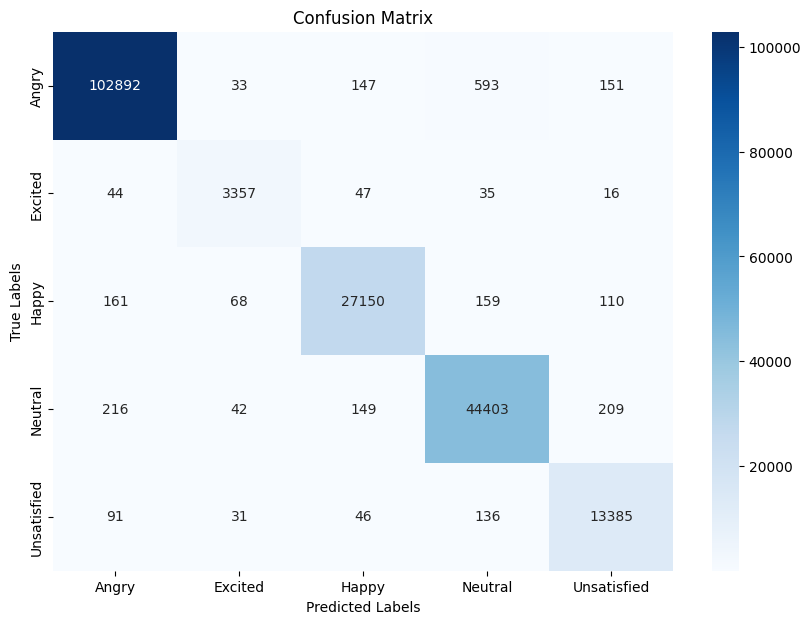

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, labels=classifier.classes_)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**This visualization will helps us understand how well the classifier is performing and where it might be making errors.**

                                                                                                                                                                                                                                                                                                                                       Comment  \
0                                                                                                                                                                                                                                                                                                                            Anyone from 2023?   
1                                                                                                                                                                                                                                                                                                           in space no one can hear

<ipython-input-10-408ac7b1b3b5>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


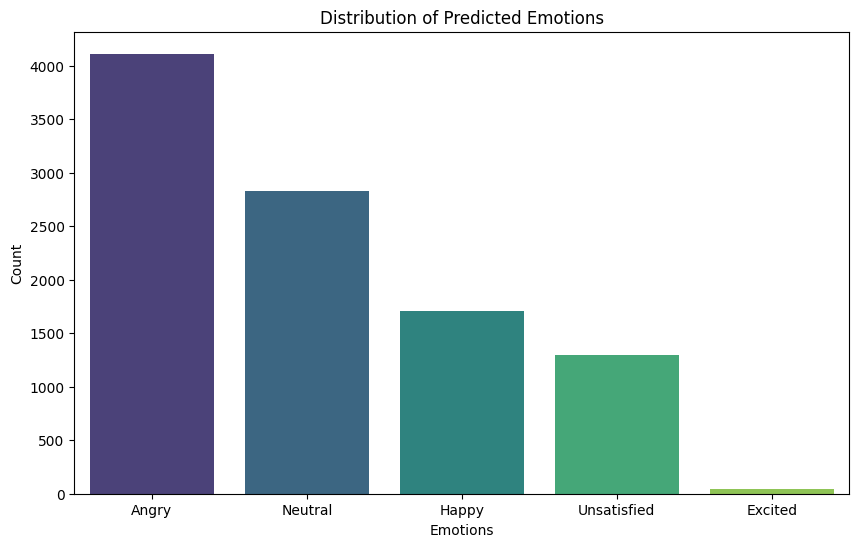

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Define a function to clean text
def clean_text(text):
    text = str(text)  # Ensure the text is a string
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Define the pipeline function with error handling
def emotion_detection_pipeline(csv_file, tfidf_vectorizer, classifier):
    try:
        # Load new data
        new_df = pd.read_csv(csv_file)
        if 'Comment' not in new_df.columns:
            raise ValueError("CSV file must contain a 'Comment' column.")

        # Clean the comments
        new_df['cleaned_comment'] = new_df['Comment'].apply(clean_text)

        # Vectorize the cleaned comments using the existing TF-IDF vectorizer
        new_tfidf_features = tfidf_vectorizer.transform(new_df['cleaned_comment'])

        # Predict emotional labels using the trained classifier
        new_df['predicted_emotion'] = classifier.predict(new_tfidf_features)

        # Display the results
        print(new_df[['Comment', 'predicted_emotion']].head(20))  # Display the first 20 results
        return new_df
    except Exception as e:
        print(f"Error: {e}")
        return None

# Function to visualize the distribution of predicted emotions
def visualize_emotions(df):
    # Count the occurrences of each predicted emotion
    emotion_counts = df['predicted_emotion'].value_counts()

    # Create a bar plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Emotions')
    plt.show()

# Example usage of the pipeline function
csv_file_path = '/content/drive/MyDrive/youtube_comments (9).csv'  # Update with the path to your new CSV file
result_df = emotion_detection_pipeline(csv_file_path, tfidf_vectorizer, classifier)

# Visualize the results if the pipeline executed successfully
if result_df is not None:
    visualize_emotions(result_df)


# The output is visible and understandable hence we have completed emotional analysis modelling

In [ ]:
# Assume combined_df already contains the cleaned comments from the previous steps

# Display the first few rows to verify
print(combined_df[['Comment', 'cleaned_comment']].head())


                                                                                                                                                                  Comment  \
0                                                                            Saw the movie yesterday. It was a good movie, but i cant compare it with the book, im sorry.   
1                                                       i began to wonder if silkworm at same place and leaves slowly moving around to ease gatheringggg or bacteria wool   
2                                                                                                                                            Has Anyone Saw This In IMAX?   
3  Dave Bautista as Yevgeny Prigozhin and Christopher Walken as Joe Biden  was excellent. If you get the points behind the scenes ...this is an excellent political movie   
4                                                                                                     No mentats after Pt 1 made no sen

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform the cleaned comments
X = vectorizer.fit_transform(combined_df['cleaned_comment'])

# Display the shape of the transformed data
print("Shape of the transformed data:", X.shape)


Shape of the transformed data: (968353, 1000)


**We used CountVectorizer to convert the cleaned text data into numerical format suitable for topic modeling**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed

# Fit   the LDA model
lda_model.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

**Train a Latent Dirichlet Allocation (LDA) model to identify topics in the comments.**

In [ ]:
# Display the top words for each topic
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# Display the top 10 words for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, n_top_words)


Topic 0:
the is like here that black and godzilla from love

Topic 1:
to you man is it the marvel we thor and

Topic 2:
this movie is looks the be so like for good

Topic 3:
the and of to in it that is was this

Topic 4:
this my cant wait in to trailer me movie for



**Extract and interpret the main topics discovered by the LDA model.**

In [ ]:
def topic_modeling_pipeline(csv_file, vectorizer, lda_model):
    # Load new data
    new_df = pd.read_csv(csv_file)

    # Clean the comments
    new_df['cleaned_comment'] = new_df['Comment'].apply(clean_text)

    # Transform the cleaned comments using the existing vectorizer
    new_X = vectorizer.transform(new_df['cleaned_comment'])

    # Predict topics using the trained LDA model
    topic_predictions = lda_model.transform(new_X)

    # Add topic predictions to the DataFrame
    for i in range(topic_predictions.shape[1]):
        new_df[f"Topic_{i+1}_probability"] = topic_predictions[:, i]

    # Display the results
    print(new_df[['Comment'] + [col for col in new_df.columns if 'Topic_' in col]].head(20))  # Display the first 20 results
    return new_df

# Example usage of the pipeline function
csv_file_path = '/content/drive/MyDrive/test 1.csv'  # Update with the path to your new CSV file
result_df = topic_modeling_pipeline(csv_file_path, vectorizer, lda_model)


                                                                                                                                                                                                                                               Comment  \
0                                                                                                                          Even the prostitute also fight for freedom of india.except savarkar&co..wo us waqt v gaddar the..aaj v uske manne wale hai.   
1                                                                                                                                                                                                    The power of nepali actresa manisha Koirala 😘😘😘😘😘   
2                                                                                                                                                                                            Pakistan got freedom because of these Heeramandi workers.   


<ipython-input-16-93365aa09b22>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


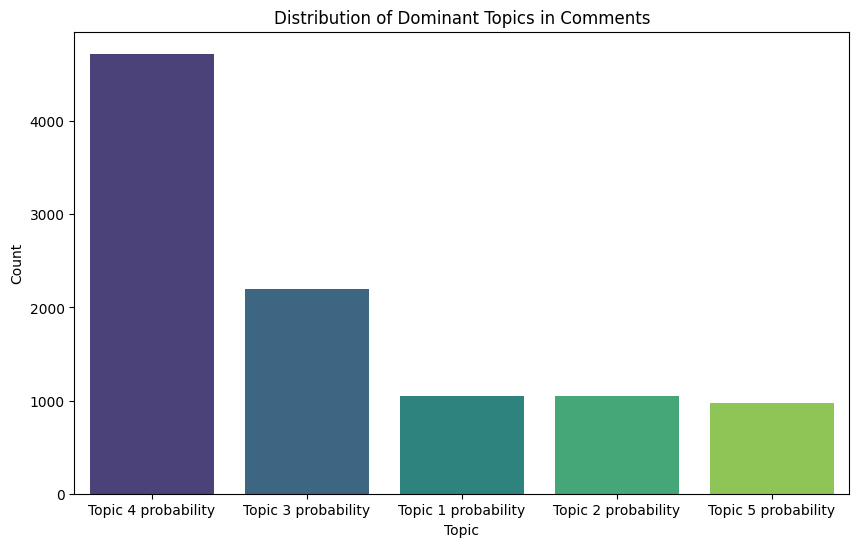

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_distribution(df):
    # Identify the most probable topic for each comment
    topic_columns = [col for col in df.columns if 'Topic_' in col]
    df['dominant_topic'] = df[topic_columns].idxmax(axis=1)

    # Count the occurrences of each topic
    topic_counts = df['dominant_topic'].value_counts()

    # Map column names to topic labels (e.g., 'Topic_1' -> 'Topic 1')
    topic_labels = {col: col.replace('_', ' ') for col in topic_columns}
    topic_counts.index = topic_counts.index.map(topic_labels)

    # Create a bar plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.title('Distribution of Dominant Topics in Comments')
    plt.show()

# Plot the distribution of topics
plot_topic_distribution(result_df)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-18-6dc4cce0c3a0>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


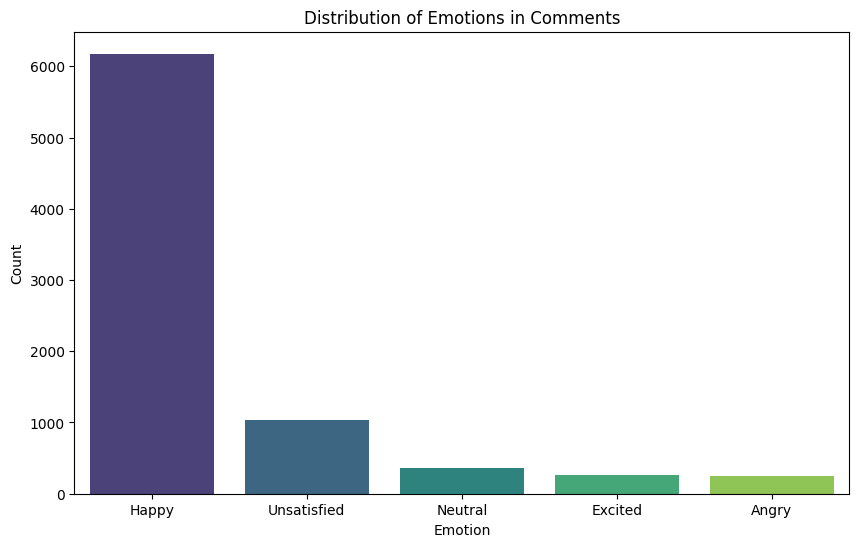

<ipython-input-18-6dc4cce0c3a0>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


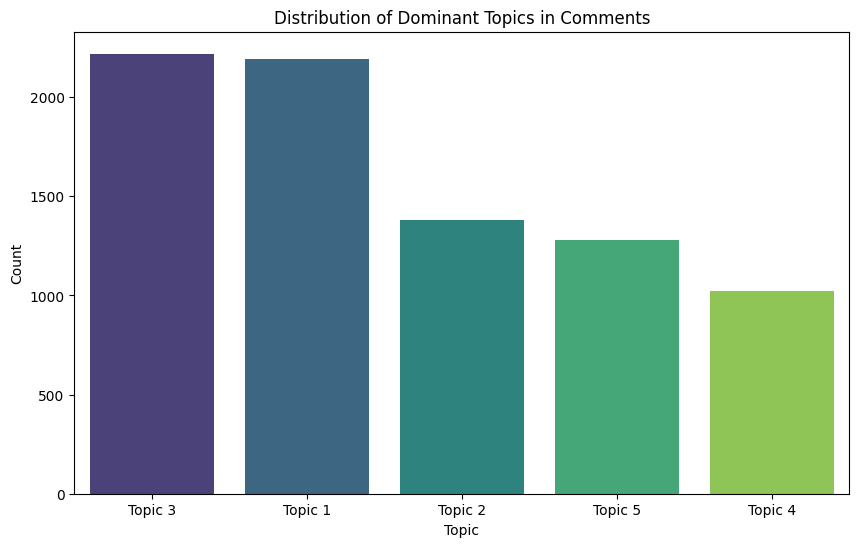

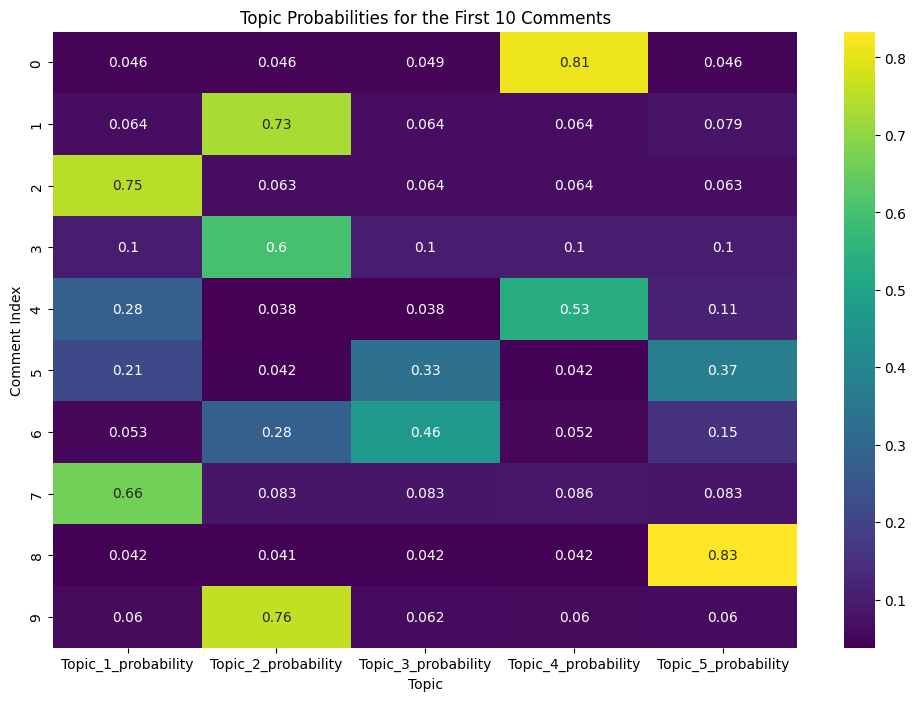

In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    else:
        return ""

# Define a function to process the new CSV file and apply both models
def process_new_csv(file_path):
    # Load new CSV file
    new_df = pd.read_csv(file_path)

    # Clean the comments
    new_df['cleaned_comment'] = new_df['Comment'].apply(clean_text)

    # Emotion Detection Model
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(new_df['cleaned_comment'])
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    new_df['emotion_cluster'] = kmeans.fit_predict(X)

    # Define a mapping of cluster IDs to emotional labels
    cluster_to_emotion = {
        0: 'Unsatisfied',  # Adjust based on your previous analysis
        1: 'Happy',
        2: 'Angry',
        3: 'Neutral',
        4: 'Excited'
    }
    new_df['emotion_label'] = new_df['emotion_cluster'].map(cluster_to_emotion)

    # Topic Modeling
    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    topic_probabilities = lda_model.fit_transform(X)

    # Add topic probabilities to DataFrame
    for i in range(5):
        new_df[f'Topic_{i+1}_probability'] = topic_probabilities[:, i]

    # Determine the dominant topic
    topic_columns = [f'Topic_{i+1}_probability' for i in range(5)]
    new_df['dominant_topic'] = new_df[topic_columns].idxmax(axis=1)

    return new_df

# Function to plot emotion distribution
def plot_emotion_distribution(df):
    emotion_counts = df['emotion_label'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Distribution of Emotions in Comments')
    plt.show()

# Function to plot topic distribution
def plot_topic_distribution(df):
    topic_counts = df['dominant_topic'].value_counts()
    topic_labels = {f'Topic_{i+1}_probability': f'Topic {i+1}' for i in range(5)}
    topic_counts.index = topic_counts.index.map(topic_labels)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.title('Distribution of Dominant Topics in Comments')
    plt.show()

# Function to plot topic probabilities heatmap
def plot_topic_probabilities(df, num_comments=10):
    sample_df = df.head(num_comments)
    topic_columns = [col for col in sample_df.columns if 'Topic_' in col]
    topic_probabilities = sample_df[topic_columns]
    plt.figure(figsize=(12, 8))
    sns.heatmap(topic_probabilities, annot=True, cmap='viridis', cbar=True)
    plt.xlabel('Topic')
    plt.ylabel('Comment Index')
    plt.title(f'Topic Probabilities for the First {num_comments} Comments')
    plt.show()

# Example usage:
file_path = '/content/drive/MyDrive/test 1.csv'  # Update this with the path to your new CSV file
result_df = process_new_csv(file_path)

# Plot the emotion distribution
plot_emotion_distribution(result_df)

# Plot the topic distribution
plot_topic_distribution(result_df)

# Plot the topic probabilities heatmap for the first 10 comments
plot_topic_probabilities(result_df, num_comments=10)
